# PPP Adjusted Average Salary and Employment Rates Across Different Countries

This project aims to scrape data on the purchasing power parity (PPP) adjusted average salary (in USD) and employment rates of various countries from the Wikipedia website using its API. The collected data will be aggregated and organised into a DataFrame. Visualizations will be created to find out:

1. What has been the growth rate of PPP adjusted average salary for these countries since 2000?
2. Is there a correlation between the employment rate and the average salary growth rate when adjusted for purchasing power?

In [27]:
#import Python libraries 
from bs4 import BeautifulSoup
import wikipedia
import pandas
import numpy
import matplotlib.pyplot as plt
import matplotlib
pandas.set_option("display.max_columns", None)
pandas.set_option("display.max_rows", None)
pandas.set_option("display.width", 1000)

<br>

### Define a list of Wikipedia page titles to be scraped and retrieve the tables from corresponding Wikipedia page using the Wikipedia API.

In [28]:
# Define a list of page titles
page_titles = ["List_of_countries_by_average_wage", "List_of_sovereign_states_by_employment_rate"]

# Initialise lists to store BeautifulSoup objects
soup_list = []

# Iterate over page titles
for title in page_titles:
    page = wikipedia.page(title, auto_suggest=False)
    if page:
        soup = BeautifulSoup(page.html(), "html.parser")
        soup_list.append(soup.find_all("table")[0])
    else:
        print(f"{title} page does not exist.")

<br>

### Extract data from tables in the soup list and assign them to DataFrames.

In [29]:
# Extract column headers from the first table in soup_list
salary_column_headers=[]
for temp in soup_list[0].find_all("th"):
    salary_column_headers.append(temp.text.strip())

# Initialise and create a DataFrame with the extracted column headers
salary_df=[]      
salary_df=pandas.DataFrame(columns=salary_column_headers)


# Extract rows of data from the first table in soup_list
rows=[]
for temp_rows in soup_list[0].find_all("tr")[1:]:
    data=[]
    # Extract data cells from each row
    for temp_data in temp_rows.find_all("td"):
        data.append(temp_data.text.strip().split("\u202f")[0])
    rows.append(data)

# Populate the DataFrame with the extracted rows of data
for temp in rows:   
      salary_df.loc[len(salary_df)]=temp

# Replace empty strings with NaN values and drop rows with NaN values
salary_df.replace("", numpy.nan, inplace=True)
salary_df.dropna(inplace=True)

print(salary_df)

           Country    2000    2010    2020    2022
0          Iceland  57,008  54,268  71,687  79,473
1       Luxembourg  64,217  71,085  74,839  78,310
2    United States  61,132  67,263  77,567  77,463
3      Switzerland  60,768  67,961  69,728  72,993
4          Belgium  60,929  63,295  63,677  64,848
5          Denmark  52,019  61,537  66,203  64,127
6          Austria  57,529  62,831  64,648  63,802
7      Netherlands  60,063  66,270  67,163  63,225
8        Australia  48,213  55,536  60,377  59,408
9           Canada  46,526  52,457  59,160  59,050
10         Germany  51,344  52,912  60,309  58,940
11  United Kingdom  44,967  52,455  53,612  53,985
12          Norway  36,444  47,531  52,415  53,756
13         Ireland  37,874  52,793  53,651  52,243
14         Finland  43,073  49,911  51,092  51,836
15     New Zealand  36,452  44,476  51,417  50,722
16          Sweden  37,651  45,337  51,214  50,407
17     South Korea  32,243  39,730  48,294  48,922
18        Slovenia  33,203  42,

<br>

In [30]:

# Extract column headers from the first table in soup_list
employment_column_headers=[]
for temp in soup_list[1].find_all("tr", class_="static-row-header")[:1]:
    for temp2 in temp.find_all("th"):
        employment_column_headers.append(temp2.text.strip())

# Initialise and create a DataFrame with the extracted column headers
employment_df=[]
employment_df=pandas.DataFrame(columns=employment_column_headers)

# Extract rows of data from the second table in soup_list
rows=[]
for temp_rows in soup_list[1].find_all("tr")[1:]:
    data=[]
    # Extract data cells from each row
    for temp_data in temp_rows.select("th,td"):
        data.append(temp_data.text.strip().split("\u202f")[0])        
    rows.append(data)

# Populate the DataFrame with the extracted rows of data
for temp in rows:      
      employment_df.loc[len(employment_df)]=temp

print(employment_df)


                   Country Rate (%)   Ages      Year                                             Source
0                  Iceland     81.9  15–64      2021                                            OECD[5]
1              Netherlands     80.8  15–64      2021                                            OECD[5]
2              Switzerland     80.1  15–64      2021                                            OECD[5]
3              New Zealand     79.2  15–64      2021                                            OECD[5]
4                    Japan     78.0  15–64      2021                                            OECD[5]
5                   Norway     77.5  15–64      2021                                            OECD[5]
6                  Germany     76.8  15–64      2021                                            OECD[5]
7                  Denmark     76.5  15–64      2021                                            OECD[5]
8                   Sweden     76.0  15–64      2021            

<br>

### Merge DataFrames and prepare data for visualisation

In [31]:
# Merge the DataFrames
combined_df = pandas.merge(salary_df, employment_df, how="inner", on="Country")

# Convert the data in selected columns from string to integer
for column in combined_df.columns[1:5]:
    combined_df[column] = combined_df[column].astype(str).str.replace(",", "").astype(int)

# Calculate the salary growth rate from 2000 to 2022
combined_df["Salary_Growth_Rate_00-22"] = (((combined_df["2022"]-combined_df["2000"])/combined_df["2022"])*100).round(2)

# Estimate the salary for 2021 and calculate the salary growth rate
combined_df["2021_Est"] = combined_df[["2020", "2022"]].mean(axis=1).astype(int)
combined_df["Salary_Growth_Rate_21_Est"] = (((combined_df["2021_Est"]-combined_df["2020"])/combined_df["2021_Est"])*100).round(2)

# Rename the "Rate (%)" column to "Employment_Rate_21"
combined_df.rename(columns={"Rate (%)": "Employment_Rate_21"}, inplace=True)

# Convert the "Employment_Rate_21" column to float and adjust the values to represent percentages
combined_df["Employment_Rate_21"]=(combined_df["Employment_Rate_21"].astype(str).str.replace(".", "").astype(float))
combined_df["Employment_Rate_21"]=combined_df["Employment_Rate_21"]/10
    
# Reorder the columns of the combined DataFrame and remove unnecessary columns
combined_df = combined_df.reindex(columns=["Country", "2000", "2010", "2020", "2021_Est", "2022", "Employment_Rate_21", "Salary_Growth_Rate_00-22", "Salary_Growth_Rate_21_Est"])

print (combined_df)

           Country   2000   2010   2020  2021_Est   2022  Employment_Rate_21  Salary_Growth_Rate_00-22  Salary_Growth_Rate_21_Est
0          Iceland  57008  54268  71687     75580  79473                81.9                     28.27                       5.15
1       Luxembourg  64217  71085  74839     76574  78310                69.4                     18.00                       2.27
2    United States  61132  67263  77567     77515  77463                70.5                     21.08                      -0.07
3      Switzerland  60768  67961  69728     71360  72993                80.1                     16.75                       2.29
4          Belgium  60929  63295  63677     64262  64848                66.0                      6.04                       0.91
5          Denmark  52019  61537  66203     65165  64127                76.5                     18.88                      -1.59
6          Austria  57529  62831  64648     64225  63802                73.3              

<br>

### Bar chart that visualises the PPP adjusted average salary growth rate between 2000 to 2022.

The growth rates vary significantly among countries, ranging from negative growth (-14.7% from Greece) to substantial positive growth (+61.02% from Lithuania), where the UK has been increasing at a steady rate of 16.7%, indicating a stable upward trend in average salaries when adjusted for purchasing power.

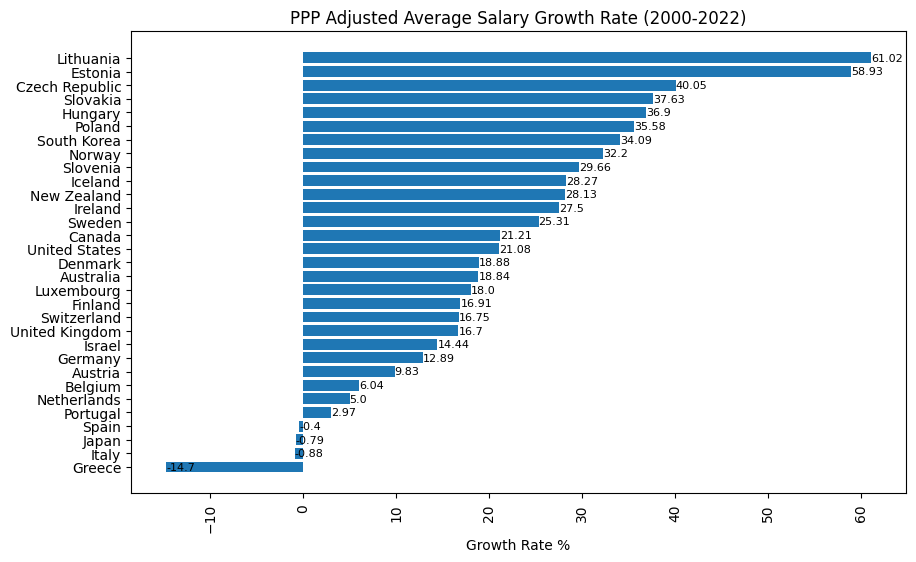

In [32]:
# Sort the DataFrame for visualisation
combined_df_sorted = combined_df.sort_values(by="Salary_Growth_Rate_00-22", ascending=True)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars=plt.barh(combined_df_sorted["Country"], combined_df_sorted["Salary_Growth_Rate_00-22"])

# Adding title, ticks and labels
plt.title("PPP Adjusted Average Salary Growth Rate (2000-2022)")
plt.xticks(rotation=90)
plt.xlabel("Growth Rate %")

# Adding data labels for each bar
for bar in bars:
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height()/2, round(xval, 2), ha="left", va="center", fontsize=8)
plt.show()

<br>

### Scatter chart that visualises the purchasing power parity (PPP) adjusted average salary and employment rate in 2021 for various countries.

There appears to be no correlation between the employment rate and the average salary growth rate when adjusted for purchasing power across the observed countries in 2021. Some countries, like Iceland, have high employment rates and significant salary growth, while others, like Japan, have high employment rates but low salary growth. The absence of a clear pattern suggests that other contextual factors beyond mere employment and salary trends could be influencing the observed results.

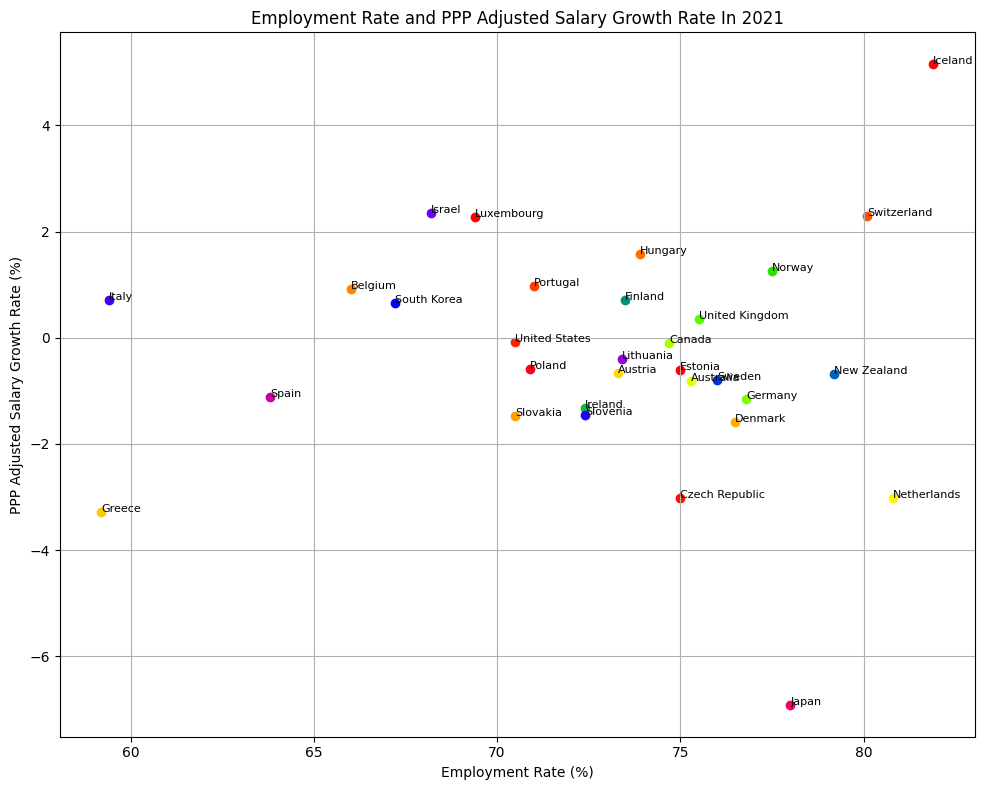

In [33]:
# Get the list of countries
countries = combined_df["Country"]

# Define a color map for countries
colour=matplotlib.colormaps.get_cmap("prism")
sizes = combined_df["Salary_Growth_Rate_21_Est"] * 5

# Plotting scatter chart
plt.figure(figsize=(10, 8))
for i, country in enumerate(countries):
    country_data = combined_df[combined_df["Country"] == country]
    plt.scatter(country_data["Employment_Rate_21"], country_data["Salary_Growth_Rate_21_Est"], color=colour(i), label=country)

# Adding labels for each point
for i, country in combined_df.iterrows():
    plt.text(country["Employment_Rate_21"], country["Salary_Growth_Rate_21_Est"], country["Country"], fontsize=8)

# Adding labels and title
plt.title("Employment Rate and PPP Adjusted Salary Growth Rate In 2021")
plt.xlabel("Employment Rate (%)")
plt.ylabel("PPP Adjusted Salary Growth Rate (%)")

# Displaying the plot
plt.grid(True)
plt.tight_layout()
plt.show()